In [9]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import time
from tqdm import tqdm

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Задание 1.1

Используя код из лекции, попробуйте обучить RNN с 2 скрытыми слоями на следующих периодичных данных и визуализируйте результат.

In [10]:
input_size = 1
hidden_size = 2

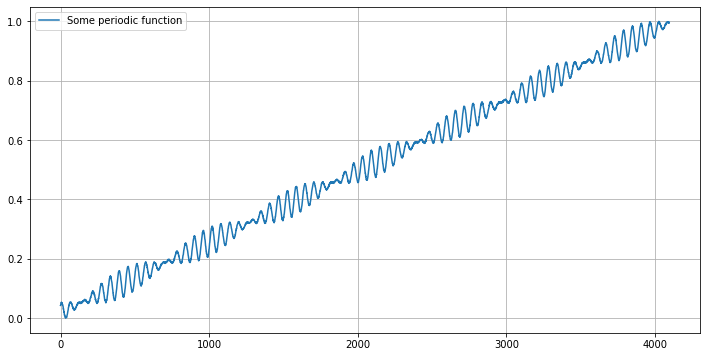

In [11]:
training_data = []
for i in range(4096):
    training_data.append(math.sin(i / 10) +
                         math.cos((i) / 9) +
                         i / 100 +
                         (random.random() - 0.5) / 5)
training_data = np.array(training_data).reshape((len(training_data), 1))
td_min = training_data.min()
td_max = training_data.max()
# Min - Max normalization
training_data -= training_data.min()
training_data = training_data / training_data.max()
# plotting
plt.figure(figsize=(12, 6))
plt.plot(training_data, label='Some periodic function')
plt.legend()
plt.grid()
plt.show()

In [12]:
import numpy as np
import torch
import torch.nn as nn
# функция создания "ансамблей" данных
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)] # seq_len * elements
        _y = data[i+seq_length] # one element
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)
    
# установка длины ансамбля. от нее практически всегда зависит точность предикта и быстродействие
seq_length = 8 # сравните 2 и 32
x, y = sliding_windows(training_data, seq_length)
x[0], y[0]

(array([[0.04231871],
        [0.04185981],
        [0.04521305],
        [0.04678999],
        [0.050717  ],
        [0.05154831],
        [0.05332963],
        [0.04986966]]),
 array([0.05149201]))

In [13]:

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))

print(trainX.shape, trainY.shape, testX.shape, testY.shape)

torch.Size([3269, 8, 1]) torch.Size([3269, 1]) torch.Size([818, 8, 1]) torch.Size([818, 1])


In [14]:
class my_RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        # hidden_size == number of neurons 
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers= num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1) # Predict only one value

    def forward(self, x):
        #print("x: ",x.shape) # 108 x 8 x 1 : [batch_size, seq_len, input_size] 
        out, h = self.rnn(x) 
        #print("out: ", out.shape) # 108 x 8 x 4 : [batch_size, seq_len, hidden_size] Useless!
        #print("h : ", h.shape) # 1 x 108 x 4 [ num_layers, batch_size, hidden_size]
        y = self.fc(h)
        #print("y",y.shape) # 1 x 108 x 1
        return y, h

In [15]:
def time_series_train(model):
  num_epochs = 2000
  learning_rate = 0.01

  criterion = torch.nn.MSELoss() # mean-squared error for regression
  optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

  # Train the model
  for epoch in range(num_epochs):
      outputs, h = model(trainX) # we don't use h there, but we can!
      optimizer.zero_grad()
      # model.h = h
      
      # obtain the loss function
      loss = criterion(outputs, trainY)
      loss.backward()
      
      optimizer.step()
      if epoch % 100 == 0:
          print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


In [16]:
input_size = 1
hidden_size = 2
num_layers = 2
time0 = time.time()
rnn = my_RNN(input_size, hidden_size, num_layers)
time_series_train(rnn)
time1 = time.time()
print(f'RNN time: {time1-time0}')

/Users/balepka/PycharmProjects/msuAI/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([3269, 1])) that is different to the input size (torch.Size([2, 3269, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: 0.91083
Epoch: 100, loss: 0.00342
Epoch: 200, loss: 0.00070
Epoch: 300, loss: 0.00048
Epoch: 400, loss: 0.00038
Epoch: 500, loss: 0.00030
Epoch: 600, loss: 0.00024
Epoch: 700, loss: 0.00019
Epoch: 800, loss: 0.00016
Epoch: 900, loss: 0.00013
Epoch: 1000, loss: 0.00011
Epoch: 1100, loss: 0.00009
Epoch: 1200, loss: 0.00007
Epoch: 1300, loss: 0.00006
Epoch: 1400, loss: 0.00004
Epoch: 1500, loss: 0.00003
Epoch: 1600, loss: 0.00002
Epoch: 1700, loss: 0.00002
Epoch: 1800, loss: 0.00002
Epoch: 1900, loss: 0.00001
RNN time: 6.642965078353882


In [17]:
def time_series_plot(train_predict):
  data_predict = train_predict.data.numpy()
  dataY_plot = dataY.data.numpy()

  # Denormalize
  data_predict = data_predict[0] *td_max + td_min
  dataY_plot = dataY_plot *td_max + td_min 
  #print(data_predict[:15])

  # Ploitting
  plt.figure(figsize=(12, 4))
  plt.axvline(x=train_size, c='r', linestyle='--')

  plt.plot(dataY_plot)
  plt.plot(data_predict)
  plt.suptitle('Time-Series Prediction')
  plt.show()



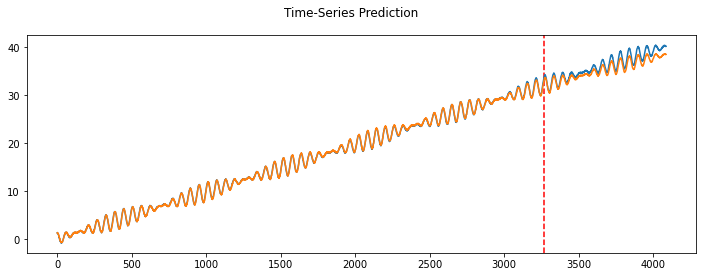

In [18]:
rnn.eval()
train_predict, h = rnn(dataX)
time_series_plot(train_predict)

# Задание 1.2

Теперь обучите на этих же данных LSTM с 2 скрытыми слоями и визуализируйте результат.

In [19]:
def lstm_train(lstm):
  lstm.train()

  num_epochs = 2000
  learning_rate = 0.01

  criterion = torch.nn.MSELoss() # mean-squared error for regression
  optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

  # Train the model
  for epoch in range(num_epochs):
      outputs, h = lstm(trainX)
      optimizer.zero_grad()
      #print(outputs.shape)
      loss = criterion(outputs, trainY.unsqueeze(0))
      loss.backward()
      
      optimizer.step()
      if epoch % 100 == 0:
          print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [20]:
class my_LSTM_1_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        # hidden_size == number of neurons 
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1) # Predict only one value

    def forward(self, x):
        #print("x: ",x.shape) # 108 x 8 x 1 : [batch_size, seq_len, input_size] 
        out, (h,c) = self.rnn(x)
        #print("out: ", out.shape) # 108 x 8 x 4 : [batch_size, seq_len, hidden_size] Useless!
        #print("h : ", h.shape) # 1 x 108 x 4 [ num_layers, batch_size, hidden_size]
        y = self.fc(out[:, -1, :])
        y = y.reshape((1, x.shape[0], 1))
        return y, h

In [21]:
input_size = 1
hidden_size = 2
num_layers = 2
time0 = time.time()
my_lstm = my_LSTM_1_2(input_size, hidden_size, num_layers)
lstm_train(my_lstm)
time1 = time.time()
print(f'lstm time: {time1-time0}')

Epoch: 0, loss: 0.44945
Epoch: 100, loss: 0.02132
Epoch: 200, loss: 0.00072
Epoch: 300, loss: 0.00034
Epoch: 400, loss: 0.00013
Epoch: 500, loss: 0.00009
Epoch: 600, loss: 0.00008
Epoch: 700, loss: 0.00007
Epoch: 800, loss: 0.00007
Epoch: 900, loss: 0.00007
Epoch: 1000, loss: 0.00006
Epoch: 1100, loss: 0.00006
Epoch: 1200, loss: 0.00006
Epoch: 1300, loss: 0.00005
Epoch: 1400, loss: 0.00005
Epoch: 1500, loss: 0.00005
Epoch: 1600, loss: 0.00004
Epoch: 1700, loss: 0.00004
Epoch: 1800, loss: 0.00004
Epoch: 1900, loss: 0.00003
lstm time: 25.65749502182007


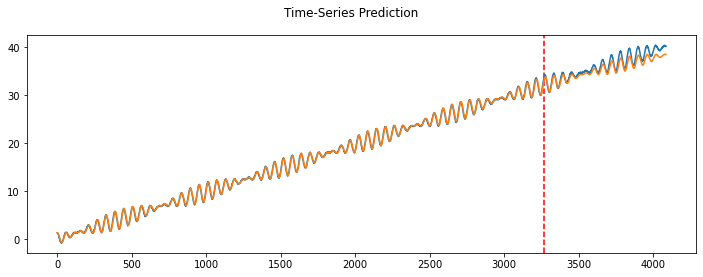

In [22]:
my_lstm.eval()
train_predict, h = my_lstm(dataX)
time_series_plot(train_predict)

# Задание 1.3

Произведите аналогичные действия с GRU моделью.

In [23]:
class my_GRU_1_3(nn.Module):

    def __init__(self, input_size, hidden_size):
        # hidden_size == number of neurons 
        super().__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1) # Predict only one value

    def forward(self, x):
        #print("x: ",x.shape) # 108 x 8 x 1 : [batch_size, seq_len, input_size] 
        out, h = self.rnn(x)
        #print("out: ", out.shape) # 108 x 8 x 4 : [batch_size, seq_len, hidden_size] Useless!
        #print("h : ", h.shape) # 1 x 108 x 4 [ num_layers, batch_size, hidden_size]
        y = self.fc(out[:, -1, :])
        y = y.reshape((1, x.shape[0], 1))
        return y, h

In [24]:
input_size = 1
hidden_size = 2
num_layers = 2
time0 = time.time()
my_gru = my_GRU_1_3(input_size, hidden_size)
lstm_train(my_gru)
time1 = time.time()
print(f'gru time: {time1-time0}')

Epoch: 0, loss: 0.08753
Epoch: 100, loss: 0.00013
Epoch: 200, loss: 0.00010
Epoch: 300, loss: 0.00008
Epoch: 400, loss: 0.00007
Epoch: 500, loss: 0.00006
Epoch: 600, loss: 0.00005
Epoch: 700, loss: 0.00004
Epoch: 800, loss: 0.00004
Epoch: 900, loss: 0.00003
Epoch: 1000, loss: 0.00003
Epoch: 1100, loss: 0.00003
Epoch: 1200, loss: 0.00002
Epoch: 1300, loss: 0.00002
Epoch: 1400, loss: 0.00002
Epoch: 1500, loss: 0.00002
Epoch: 1600, loss: 0.00002
Epoch: 1700, loss: 0.00002
Epoch: 1800, loss: 0.00002
Epoch: 1900, loss: 0.00002
gru time: 10.477837085723877


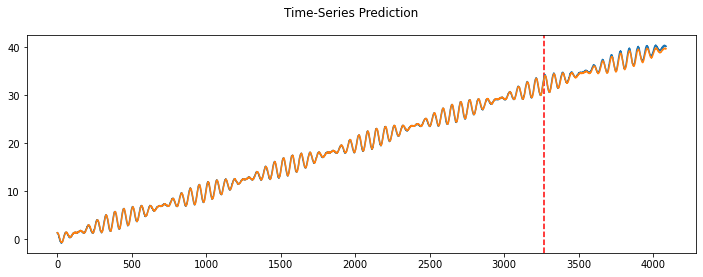

In [25]:
my_gru.eval()
train_predict, h = my_gru(dataX)
time_series_plot(train_predict)

# Задание 1.4

Сравните результаты и скорость работы RNN, LSTM и GRU. 

Наиболее точный оказался LSTM (хотя loss наименьший у RNN), схожие (неплохие) результаты показали LSTM и RNN. Наиболее быстрый - RNN (11 с), заметно более медленный  LSTM (57 с), GRU - посередине (23 с).

# Задание 2

Возьмите следующий набор данных и, используя код из лекции, создайте реккурентную сеть для генерации фамилий. Для ускорения обучения переносите данные и модель на видеокарту. Подумайте, как получить разные фамилии, начинающиеся на одну и ту же букву.


In [27]:
import gdown
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import time

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
DEVICE = 'cuda'

!pip install gdown

surnames_url = 'https://drive.google.com/uc?id=1-hODpM4XoGOzJP2dUVQDww1gVKkWt_jm'
surnames_file_name = 'surnames.txt'
gdown.download(surnames_url,
               surnames_file_name, quiet=False)

You should consider upgrading via the '/Users/balepka/PycharmProjects/msuAI/venv/bin/python -m pip install --upgrade pip' command.


Downloading...
From: https://drive.google.com/uc?id=1-hODpM4XoGOzJP2dUVQDww1gVKkWt_jm
To: /Users/balepka/PycharmProjects/msuAI/surnames.txt
100%|██████████| 759k/759k [00:00<00:00, 1.14MB/s]


'surnames.txt'

In [28]:
with open(surnames_file_name, encoding='utf-8') as s_file:
    surnames_list = [line.strip().lower() for line in s_file.readlines()]

In [29]:
string = ''.join(set(''.join(surnames_list)))
LETTERS = string
print(LETTERS)
charset_size = len(LETTERS) + 1
char_index = {char: i for i, char in enumerate(LETTERS)}
inverse_index = {i: char for char, i in char_index.items()}
inverse_index[charset_size - 1] = "<EOS>"

еипьхгбоякыщфлэътуаюёйсрцндзвчжмш


In [30]:
LETTERS

'еипьхгбоякыщфлэътуаюёйсрцндзвчжмш'

In [31]:
def tensorize(word: str):
    letter_indexes = [char_index[char] for char in word]
    input_tensor = torch.LongTensor(letter_indexes)

    eos = torch.zeros(1).type(torch.LongTensor) + (len(LETTERS))
    target_tensor = torch.cat((input_tensor[1:], eos))

    return input_tensor, target_tensor

In [32]:
class SurnamesDataset(torch.utils.data.Dataset):
    def __init__(self, my_list, n_samples=5000):
        self.n_samples = n_samples
        self.samples = random.choices(my_list, k=n_samples)


    def __len__(self):
        return len(self.samples)

    
    def __getitem__(self, idx):
        return tensorize(self.samples[idx])


In [33]:
names = SurnamesDataset(surnames_list, n_samples=10000)
name_loader = torch.utils.data.DataLoader(names, batch_size=1, shuffle=True)


In [34]:
class CharLSTM(torch.nn.Module):
    def __init__(
        self,
        charset_size: int,
        hidden_size: int,
        embedding_dim: int = 8,
        num_layers: int = 2
    ):
        super(CharLSTM, self).__init__()

        self.charset_size = charset_size
        self.hidden_size = hidden_size
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = torch.nn.Embedding(charset_size, embedding_dim)
        self.lstm = torch.nn.LSTM(
            embedding_dim,
            hidden_size,
            batch_first=True,
            num_layers=num_layers,
            dropout=0.5
        )
        self.decoder = torch.nn.Linear(hidden_size, charset_size)
        self.dropout = torch.nn.Dropout(p=0.25)
        self.softmax = torch.nn.LogSoftmax(dim=2)

    def forward(self, input_tensor, hidden_state):
        embedded = self.embedding(input_tensor)
        output, hidden_state = self.lstm(embedded, hidden_state)
        output = self.decoder(output)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden_state

    def init_hidden(self):
        return (
            torch.zeros(self.num_layers, 1, self.hidden_size),
            torch.zeros(self.num_layers, 1, self.hidden_size)
        )

In [35]:
rnn = CharLSTM(charset_size, hidden_size=128, embedding_dim=8, num_layers=2)

In [36]:
def sample(
    seed: str,
    max_len: int = 10,
    break_on_eos: bool = True,
    eval_mode: bool = True):
    if eval_mode:
        rnn.eval()


    with torch.no_grad():
        input_tensor, _ = tensorize(seed)
        # print(input_tensor)
        hidden = rnn.init_hidden()

        input_tensor = input_tensor.unsqueeze(0)


        output_name = seed
        for _ in range(max_len):
            out, hidden = rnn(input_tensor, hidden)
            _, topi = out[:, -1, :].topk(1) 
            next_char = inverse_index[int(topi.squeeze())]
            # print(f'ind = {int(topi.squeeze())}')
            # print(f'next char = {next_char}') 

            if break_on_eos and (next_char == "<EOS>"):
                break
            output_name += next_char
            input_tensor = topi

    rnn.train()
    return output_name

In [37]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.RMSprop(rnn.parameters(), lr=0.001)

def train_step(
    input_tensor: torch.LongTensor,
    target_tensor: torch.LongTensor):
  
    optimizer.zero_grad()

    hidden = rnn.init_hidden()
    output, hidden = rnn(input_tensor, hidden)

    # target_tensor = target_tensor.unsqueeze(0)
    # print(f'tar = {target_tensor[0, :].shape}')
    # print(f'out = {output[0, :, :].shape}')
    loss = criterion(output[0, :, :], target_tensor[0, :])

    loss.backward()  
    optimizer.step()  

    return loss.item() 

In [38]:
losses = []
running_loss = 0.0
n_epochs = 5

for epoch in range(n_epochs):
    looper = tqdm(name_loader, desc=f"epoch {epoch + 1}")
    for i, tensors in enumerate(looper):
        # print(tensors)
        loss = train_step(*tensors)
        running_loss += loss
        losses.append(loss)
        if (i+1) % 50 == 0:
            looper.set_postfix({"Loss": running_loss/50.})
            running_loss = 0

epoch 5: 100%|██████████| 10000/10000 [00:24<00:00, 415.86it/s, Loss=2.2]


В модели есть dropout, если отключить функцию eval, получается немного разная нейросесть каждый раз - генерирует разные имена на одну и ту же букву.

In [39]:
seed = 'п'
for _ in range(10):
    print(f"{seed} --> {sample(seed, eval_mode=False)}")

п --> полодов
п --> поренов
п --> поросова
п --> пореушкинау
п --> патриков
п --> породев
п --> пельковский
п --> потов
п --> парасов
п --> полодов


In [40]:
for _ in range(10):
    seed = random.choice(LETTERS)
    print(f"{seed} --> {sample(seed)}")

п --> полодов
с --> саранов
х --> харин
д --> данин
г --> гаранов
ж --> жаранов
я --> яров
у --> уранов
п --> полодов
б --> баранов


# Задание 3

Возьмите произведение Гете "Фауст" и обучите на нем LSTM модель для посимвольной генерации текста.


In [41]:
import gdown
import math
import random
from collections import Counter

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import time

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
DEVICE = 'cuda'

!pip install gdown

You should consider upgrading via the '/Users/balepka/PycharmProjects/msuAI/venv/bin/python -m pip install --upgrade pip' command.


In [42]:
surnames_url = 'https://drive.google.com/uc?id=1R8j3JOXslnepnU8axVI9SUr0n5U8spy0'
faust_text_file = 'Faust.txt'
gdown.download(surnames_url, faust_text_file, quiet=False)


with open(faust_text_file) as text_file:
    faust_text = ''.join(text_file.readlines())

Downloading...
From: https://drive.google.com/uc?id=1R8j3JOXslnepnU8axVI9SUr0n5U8spy0
To: /Users/balepka/PycharmProjects/msuAI/Faust.txt
100%|██████████| 667k/667k [00:00<00:00, 1.11MB/s]


In [43]:
faust_text = faust_text.replace('\n', ' ')

In [44]:
len(faust_text)

372321

In [45]:
text_size = len(faust_text)
batch_length = 50 #number of chars to feed our NN

string = ''.join(set(''.join(faust_text)))
LETTERS = string
print(LETTERS)
charset_size = len(LETTERS) + 1
char_index = {char: i for i, char in enumerate(LETTERS)}
inverse_index = {i: char for char, i in char_index.items()}
inverse_index[charset_size - 1] = "<EOS>"

еипь;хг-,.б о«якыщф!лэ?ъ»туаюёйсрндц:зв…чж–мш


In [46]:
def tensorize(word: str):
    letter_indexes = [char_index[char] for char in word]
    input_tensor = torch.LongTensor(letter_indexes)

    eos = torch.zeros(1).type(torch.LongTensor) + (len(LETTERS))
    target_tensor = torch.cat((input_tensor[1:], eos))

    return input_tensor, target_tensor

In [47]:
class FaustDataset(torch.utils.data.Dataset):
    def __init__(self, full_text, n_samples=5000, string_length=50):
        self.length = len(full_text)
        self.n_samples = n_samples
        rand_numbers = [random.randint(0, self.length-string_length) for _ in range(n_samples)]
        self.samples = [full_text[i:i+string_length] for i in rand_numbers]


    def __len__(self):
        return len(self.samples)

    
    def __getitem__(self, idx):
        return tensorize(self.samples[idx])


In [48]:
texts = FaustDataset(faust_text, n_samples=10000, string_length = 50)
texts_loader = torch.utils.data.DataLoader(texts, batch_size=1, shuffle=True)


In [49]:
''.join([inverse_index[int(x)] for x in texts[0][0]])


'о сих пор. стальная булава! такой давно я жажду вс'

In [50]:
class CharLSTM(torch.nn.Module):
    def __init__(
        self,
        charset_size: int,
        hidden_size: int,
        embedding_dim: int = 8,
        num_layers: int = 2
    ):
        super(CharLSTM, self).__init__()

        self.charset_size = charset_size
        self.hidden_size = hidden_size
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = torch.nn.Embedding(charset_size, embedding_dim)
        self.lstm = torch.nn.LSTM(
            embedding_dim,
            hidden_size,
            batch_first=True,
            num_layers=num_layers,
            dropout=0.5
        )
        self.decoder = torch.nn.Linear(hidden_size, charset_size)
        self.dropout = torch.nn.Dropout(p=0.25)
        self.softmax = torch.nn.LogSoftmax(dim=2)

    def forward(self, input_tensor, hidden_state):
        embedded = self.embedding(input_tensor)
        output, hidden_state = self.lstm(embedded, hidden_state)
        output = self.decoder(output)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden_state

    def init_hidden(self):
        return (
            torch.zeros(self.num_layers, 1, self.hidden_size),
            torch.zeros(self.num_layers, 1, self.hidden_size)
        )

In [51]:
faust_rnn = CharLSTM(charset_size, hidden_size=128, embedding_dim=8, num_layers=2)

In [52]:
def sample(
    seed: str,
    max_len: int = 30,
    break_on_eos: bool = True,
    eval_mode: bool = True):
    if eval_mode:
        faust_rnn.eval()


    with torch.no_grad():
        input_tensor, _ = tensorize(seed)
        # print(input_tensor)
        hidden = faust_rnn.init_hidden()

        input_tensor = input_tensor.unsqueeze(0)


        output_name = seed
        for _ in range(max_len):
            out, hidden = faust_rnn(input_tensor, hidden)
            _, topi = out[:, -1, :].topk(1) 
            next_char = inverse_index[int(topi.squeeze())]
            # print(f'ind = {int(topi.squeeze())}')
            # print(f'next char = {next_char}') 

            if break_on_eos and (next_char == "<EOS>"):
                break
            output_name += next_char
            input_tensor = topi

    faust_rnn.train()
    return output_name

In [53]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.RMSprop(faust_rnn.parameters(), lr=0.001)

def train_step(
    input_tensor: torch.LongTensor,
    target_tensor: torch.LongTensor):
  
    optimizer.zero_grad()

    hidden = faust_rnn.init_hidden()
    output, hidden = faust_rnn(input_tensor, hidden)

    # target_tensor = target_tensor.unsqueeze(0)
    # print(f'tar = {target_tensor[0, :].shape}')
    # print(f'out = {output[0, :, :].shape}')
    loss = criterion(output[0, :, :], target_tensor[0, :])

    loss.backward()  
    optimizer.step()  

    return loss.item()

In [54]:
losses = []
running_loss = 0.0
n_epochs =5

for epoch in range(n_epochs):
    looper = tqdm(texts_loader, desc=f"epoch {epoch + 1}")
    for i, tensors in enumerate(looper):
        # print(tensors)
        loss = train_step(*tensors)
        running_loss += loss
        losses.append(loss)
        if (i+1) % 50 == 0:
            looper.set_postfix({"Loss": running_loss/50.})
            running_loss = 0 
      

epoch 5: 100%|██████████| 10000/10000 [01:54<00:00, 87.17it/s, Loss=2.43]


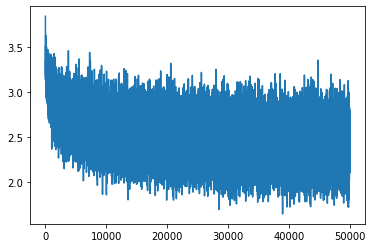

In [55]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

В модели есть dropout, если отключить функцию eval, получается немного разная нейросесть каждый раз - генерирует разные имена на одну и ту же букву.

In [67]:
seed = 'у'
for _ in range(10):
    print(f"{seed} --> {sample(seed, eval_mode=False)}")

у --> уда в под немала, все пологой! 
у --> у приветливо старань не путь по
у --> усть получит совершине с нам пр
у --> ут свет веселья свободный сказу
у --> у привет тебой подарно подавой 
у --> удил всо все в поромне с весель
у --> у привет в привет всюки с ней п
у --> ут своей,фа в полуждала в полно
у --> у постанет свой представат стан
у --> у в полезал поконет вся покорны


In [69]:
for _ in range(10):
    seed = random.choice(LETTERS)
    print(f"{seed} --> {sample(seed, eval_mode=False)}")

« --> «годобность в сердце придет в м
  -->  все в поромный, вот полон. пос
с --> сторо и встречен в собой святой
е --> е всяет все привет в страх свой
- --> -должный,е строится в сердца пр
ц --> цер сомнество пришли не вотренн
? --> ? в тарок на вершине, чегно пок
; --> ;ъа в полнось, в подобка под не
п --> полненных свой, все поставил св
у --> у в предволный! все породной со


# Задание 4

Возьмите набор данных эмоциональных окрасок отзывов fetch_20newsgroups. Получите эмбединг из трансформера BERT и классифицируйте при помощи логистической регрессии.


In [27]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 3.1 MB 5.5 MB/s 
     |████████████████████████████████| 61 kB 449 kB/s 
     |████████████████████████████████| 596 kB 48.7 MB/s 
     |████████████████████████████████| 3.3 MB 20.5 MB/s 
     |████████████████████████████████| 895 kB 57.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 298 kB 5.4 MB/s 
     |████████████████████████████████| 132 kB 55.8 MB/s 
     |████████████████████████████████| 243 kB 38.5 MB/s 
     |████████████████████████████████| 1.1 MB 45.6 MB/s 
     |████████████████████████████████| 192 kB 47.5 MB/s 
     |████████████████████████████████| 160 kB 48.3 MB/s 
     |████████████████████████████████| 271 kB 49.1 MB/s 


In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

In [29]:
train = load_dataset("emotion", split="train")
train_df = pd.DataFrame({'text': train['text'], 'emotion': train['label']})
train_df.head()

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


,text,emotion
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [30]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
def convert_to_features(df, tokenizer, model):
  tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  tokenized2 = tokenized.apply(lambda x: np.pad(x, (0, 87 - len(x))))
  tokenized2 = np.vstack(tokenized2)
  attention_mask = np.where(tokenized2 != 0, 1, 0)
  attention_mask.shape
  input_ids = torch.tensor(tokenized2)  
  attention_mask = torch.tensor(attention_mask)

  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask)
  features = last_hidden_states[0][:,0,:].numpy()
  labels = df['emotion']
  labels = np.array(labels)
  return features, labels





In [32]:
test = load_dataset("emotion", split="test")
test_df = pd.DataFrame({'text': test['text'], 'emotion': test['label']})
test_df.head()

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


,text,emotion
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0


In [33]:
features, labels = convert_to_features(train_df[:2048], tokenizer, model)


In [34]:
my_clf = LogisticRegression(random_state=42).fit(features, labels)
right = 0

In [35]:
my_X, my_y = convert_to_features(test_df, tokenizer, model)
y_pred = my_clf.predict(my_X)
acc = np.count_nonzero(y_pred == my_y)/y_pred.shape[0]

In [36]:
acc

0.5345